In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import numpy as np
from atl_module.geospatial_utils.raster_interaction import (
    query_raster,
    query_from_lines,
)
import matplotlib.pyplot as plt
from atl_module.bathymetry_extraction.refraction_correction import correct_refr
from atl_module.plotting import set_size

# aggregation functions

In [3]:
# defining some useful aggregation functions

rms_lambda = lambda x: np.sqrt(np.mean(np.square(x)))
mae_lambda = lambda x: np.mean(np.abs(x))

# this is just for by-trackline groupbys
def agg_photon_counts(arr):
    assert np.all(
        arr == arr[0]
    ), "the groupby must be by tracklines with identical values for `n_subsurf_points` and `n_total_points`"
    return arr[0]


# this dictionary can be unpacked into .agg() to create summary table with named columns. can only be used with the bathymetry points GDF since its based on the expected column names
unpackable_error_dict = {
    "RMS Error [m]": pd.NamedAgg(column="error", aggfunc=rms_lambda),
    "MAE [m]": pd.NamedAgg(column="error", aggfunc=mae_lambda),
    "Mean Error [M]": pd.NamedAgg(column="error", aggfunc=np.mean),
    # the total number of points for any grouping is the count of entries in the bathy points gdf
    # the column X, which is the latitude, its used because it always has a valid value
    "n bathy points": pd.NamedAgg(column="X", aggfunc="count"),
    # to get the number of subsurface photons, we can take the mean because it will be the same if we are averaging by site and unique trackline
    # uses a function that raises an error if the points aren't all the same
    # "n photons":pd.NamedAgg(column='n_total_points',aggfunc=agg_photon_counts),
    # "n subsurf photons":pd.NamedAgg(column='n_subsurf_points',aggfunc=agg_photon_counts)
}

# get all AOIs

In [4]:
aoidflist = []
for aoifile in glob("../data/test_sites/*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)

# get all secchi depth points

In [5]:
secchi_pt_list = []
for file in glob("../data/test_sites/*/secchi_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    secchi_pt_list.append(df)

secchi_pt_combined = pd.concat(secchi_pt_list).reset_index(drop=True)

secchi_pt_combined = secchi_pt_combined.assign(
    X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
)

# get all tracklines

In [6]:
# tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/*/tracklines')]

tracklinesdflist = []
for file in glob("../data/test_sites/*/tracklines"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    tracklinesdflist.append(df)

tracklines_combined = pd.concat(tracklinesdflist).reset_index(drop=True)
tracklines_combined = tracklines_combined.assign(
    date=pd.to_datetime(tracklines_combined.date).dt.date
)

tracklines_combined.sort_values("avg_ph_cou")

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,geometry,site
880,processed_ATL03_20190115094052_02740207_005_01,gt1l,274,2019-01-15,strong,5,96.328679,1.000000,0.000000,184.521091,"LINESTRING (-157.83223 21.56362, -157.83208 21...",oahu5
504,processed_ATL03_20200713073941_02740807_005_01,gt2r,274,2020-07-13,weak,34,95.260816,1.147059,0.000000,6218.042512,"LINESTRING (-157.95395 21.27779, -157.95125 21...",oahu1
1182,processed_ATL03_20210507051755_06631101_005_01,gt3r,663,2021-05-07,strong,20,96.302326,1.150000,0.000000,638.312852,"LINESTRING (-158.28003 21.55493, -158.28069 21...",oahu8
431,processed_ATL03_20220531053325_10561501_005_02,gt2l,1056,2022-05-31,strong,216,96.222648,1.310185,0.000000,14332.084721,"LINESTRING (-81.14391 24.61500, -81.15778 24.7...",florida_keys
491,processed_ATL03_20200413115954_02740707_005_01,gt3l,274,2020-04-13,weak,55,95.813700,1.327273,0.000000,6129.874607,"LINESTRING (-157.97985 21.27356, -157.97778 21...",oahu1
...,...,...,...,...,...,...,...,...,...,...,...,...
1045,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,209501,3.120823,2726.849695,0.000000,2851.411856,"LINESTRING (-158.20881 21.57528, -158.21371 21...",oahu7
1141,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,850030,3.120823,2727.128385,0.000000,9954.309631,"LINESTRING (-158.17409 21.37328, -158.18971 21...",oahu8
1033,processed_ATL03_20190915220417_12190407_005_01,gt1l,1219,2019-09-15,weak,255324,0.000000,2882.606555,0.000000,3234.898573,"LINESTRING (-158.16393 21.57320, -158.16248 21...",oahu7
1145,processed_ATL03_20200606211436_11050701_005_01,gt3l,1105,2020-06-06,strong,216092,2.836104,3122.430442,0.000000,2382.689088,"LINESTRING (-158.10246 21.31773, -158.10621 21...",oahu8


# Concatenate all bathymetry points from all sites

In [7]:
dflist = []
for file in glob("../data/test_sites/*/all_bathy_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    dflist.append(df)

bathy_pts_df = pd.concat(dflist).reset_index(drop=True).dropna()

bathy_pts_df = bathy_pts_df.assign(date=pd.to_datetime(bathy_pts_df.delta_time).dt.date)

# looking into refraction correction

<AxesSubplot:xlabel='p_vec_elev', ylabel='p_vec_az'>

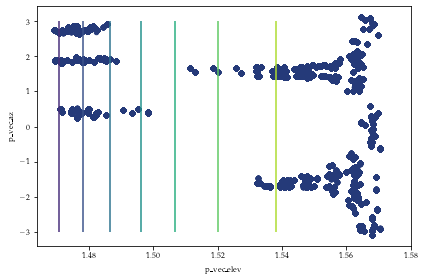

In [8]:
fig, ax = plt.subplots()

az_vecs = np.linspace(-3, 3, 1000)
elev_vecs = np.linspace(1.47, 1.58, 1000)
azgrid, elevgrid = np.meshgrid(az_vecs, elev_vecs)
xcorr, ycorr, zcorr = correct_refr(5, azgrid, elevgrid)

ax.contour(elevgrid, azgrid, zcorr)
bathy_pts_df.plot.scatter(x="p_vec_elev", y="p_vec_az", ax=ax)

In [9]:
el1 = bathy_pts_df.p_vec_elev.max()
az1 = bathy_pts_df.p_vec_az.iloc[bathy_pts_df.p_vec_elev.idxmax()]

In [10]:
correct_refr(10, el1, az1)

(7.236219752462812, 0.001997522355531652, -1.0123863696347617)

## Some stats about all the total batymetry points found

do we see a spike around 2.3 or 4.2 due to ringing?


In [11]:
# set bin edges to encapsulate the location where ringing occurs
binedges = np.arange(-25.05, 0.6, 0.1)
# 2.3 or 4.2 m

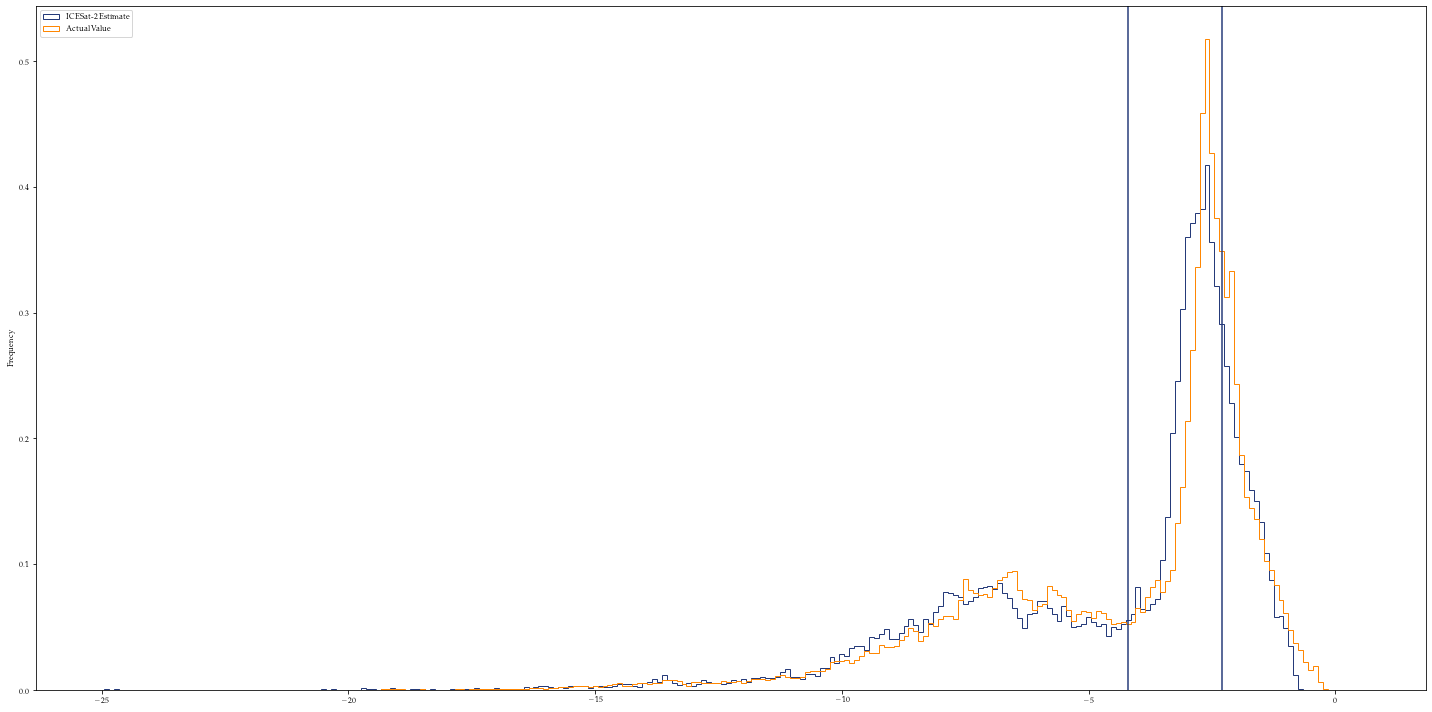

In [12]:
ax = bathy_pts_df.sf_elev_MSL.plot.hist(
    bins=binedges,
    histtype="step",
    density=True,
    label="ICESat-2 Estimate",
    figsize=(20, 10),
)
bathy_pts_df.true_elevation.plot.hist(
    ax=ax, bins=binedges, histtype="step", density=True, label="Actual Value"
)
# ax.set_xlim((-25,0))
ax.axvline(-2.3)
ax.axvline(-4.2)
ax.legend(loc="upper left")

In [13]:
error_by_site = bathy_pts_df.groupby("site").agg(**unpackable_error_dict).round(2)
error_by_site

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,
charlotteamalie,1.08,0.56,-0.17,14214
florida_keys,0.83,0.32,0.21,261200
oahu1,1.16,0.77,0.54,3207
oahu2,10.60,1.45,1.41,4326
oahu3,1.24,0.46,0.30,18217
oahu4,0.61,0.39,0.26,6646
oahu5,0.73,0.50,0.27,10315
oahu6,2.42,1.76,-1.43,754
oahu7,1.11,0.72,-0.02,2890


based on the graph above we do not see significant deviation from the overall distribution of true bathymetry.

# Sites by Secchi Depth

In [14]:
secchi_pt_combined = secchi_pt_combined.assign(
    gebco_elev=query_raster(
        secchi_pt_combined.assign(
            X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
        ),
        "../data/GEBCO/GEBCO_2021_sub_ice_topo.nc",
    )
)
# mask out values based on GEBCO elevation
secchi_pt_combined = secchi_pt_combined[secchi_pt_combined.gebco_elev < 0]

In [15]:
zsd_date_beam = (
    secchi_pt_combined.dropna()
    .groupby(["site", secchi_pt_combined.date, "beam"])
    .median()
    .reset_index()
)

Text(0.5, 0.98, '')

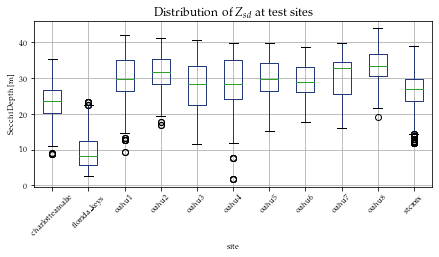

In [16]:
fig, ax = plt.subplots(figsize=set_size())
ax = secchi_pt_combined.boxplot(column="zsd", by="site", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Secchi Depth [m]")
ax.set_title("Distribution of $Z_{sd}$ at test sites")
fig.suptitle(None)

In [17]:
fig.savefig("../document/figures/secchi_by_site_boxplot.pdf")
# fig.savefig('../document/figures/secchi_by_site_boxplot.pgf',backend='pgf')

In [18]:
secchi_pt_combined.groupby("site").median().merge(
    error_by_site, left_index=True, right_index=True
)

,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,,,,,,,,
charlotteamalie,23.515282,23.920000,0.039698,29.109999,-64.911919,18.345750,-31.0,1.08,0.56,-0.17,14214
florida_keys,8.286758,56.009998,0.095968,74.010002,-80.986446,24.744184,-3.0,0.83,0.32,0.21,261200
oahu1,29.702919,29.519999,0.033219,32.989998,-157.910539,21.276661,-40.0,1.16,0.77,0.54,3207
oahu2,31.586966,28.969999,0.031779,32.270000,-157.679485,21.270529,-47.0,10.60,1.45,1.41,4326
oahu3,28.434975,50.919998,0.034304,59.230000,-157.682220,21.363550,-29.0,1.24,0.46,0.30,18217
oahu4,28.425524,27.139999,0.034313,45.480000,-157.747833,21.474975,-45.0,0.61,0.39,0.26,6646
oahu5,29.843815,25.480000,0.033104,32.930000,-157.917571,21.672136,-34.0,0.73,0.50,0.27,10315
oahu6,28.927444,31.820000,0.033870,32.299999,-157.987923,21.718169,-39.5,2.42,1.76,-1.43,754
oahu7,32.762161,25.539999,0.030973,32.254999,-158.191102,21.599575,-32.0,1.11,0.72,-0.02,2890


The code below makes the table prettier by dropping extraneous columns, renaming the sites to actual names instead of filenames, and adding latex formatted table anmes

In [19]:
# tracklines_by_site = tracklines_combined.groupby(["site"]).median()
tracklines_by_site = (
    secchi_pt_combined.groupby("site")
    .median()
    .merge(error_by_site, left_index=True, right_index=True)
    .drop(columns=["X", "Y", "gebco_elev", "diff_atten", "diff_atten_unc"])
)
namelist = [
    "St. Thomas/St. John",
    "Florida Keys",
    "Oahu 1",
    "Oahu 2",
    "Oahu 3",
    "Oahu 4",
    "Oahu 5",
    "Oahu 6",
    "Oahu 7",
    "Oahu 8",
    "St. Croix",
]

tracklines_by_site["Site Name"] = namelist
output_table = (
    tracklines_by_site.round(4)
    .set_index("Site Name")
    .rename(
        columns={
            "zsd": "$Zsd_{50}$[m]",
            "sigma_zsd": "$Zsd_{50}$ uncertainty",
            "diff_atten": "Median $Kd_{490}$",
            "diff_atten_unc": "median $Kd_{490}$ uncertainty",
        }
    )
)
output_table

,$Zsd_{50}$[m],$Zsd_{50}$ uncertainty,RMS Error [m],MAE [m],Mean Error [M],n bathy points
Site Name,,,,,,
St. Thomas/St. John,23.5153,23.92,1.08,0.56,-0.17,14214
Florida Keys,8.2868,56.01,0.83,0.32,0.21,261200
Oahu 1,29.7029,29.52,1.16,0.77,0.54,3207
Oahu 2,31.5870,28.97,10.60,1.45,1.41,4326
Oahu 3,28.4350,50.92,1.24,0.46,0.30,18217
Oahu 4,28.4255,27.14,0.61,0.39,0.26,6646
Oahu 5,29.8438,25.48,0.73,0.50,0.27,10315
Oahu 6,28.9274,31.82,2.42,1.76,-1.43,754
Oahu 7,32.7622,25.54,1.11,0.72,-0.02,2890


In [20]:
output_table.to_latex(
    "../document/tables/secchi_site.tex",
    float_format="%.2f",
    escape=False,
    label="tab:ocean_color_summary_by_site",
    caption="Secchi Depth and RMSE for each site",
)

/tmp/ipykernel_4280/4188188656.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  output_table.to_latex(


# analysis by photon

In [21]:
bathy_pts_df.columns

Index(['X', 'Y', 'Z_ellip', 'Z_geoid', 'geoid_corr', 'tide_ocean_corr',
       'geof2m_corr', 'delta_time', 'oc_sig_conf', 'land_sig_conf', 'p_vec_az',
       'p_vec_elev', 'dac_corr', 'ph_count', 'full_sat', 'gebco_elev',
       'sea_level_interp', 'sea_level_std_dev', 'Z_refr', 'easting_corr',
       'northing_corr', 'z_kde', 'kde_val', 'beam', 'atm_profile', 'beamtype',
       'oc_hconf_perc', 'n_subsurf_points', 'n_total_points', 'easting_raw',
       'northing_raw', 'sf_elev_MSL', 'true_elevation', 'error', 'error_abs',
       'geometry', 'site', 'date'],
      dtype='object')

(0.0, 500.0)

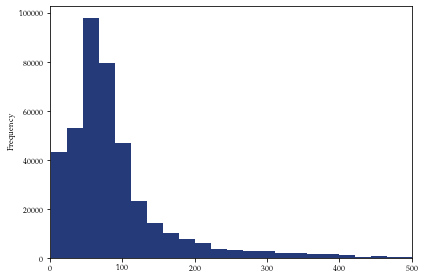

In [22]:
ax = bathy_pts_df.ph_count.plot.hist(bins=100)
ax.set_xlim((0,500))

In [23]:
bathy_pts_df = bathy_pts_df[bathy_pts_df.true_elevation<0]

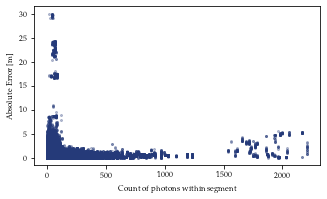

In [24]:
ax = bathy_pts_df.plot.scatter(y='error_abs',x='ph_count',figsize=set_size(fraction=0.75),ylabel='Absolute Error [m]',rasterized=True,xlabel='Count of photons within segment',s=4,alpha=0.3)
# ax.rast
ax.get_figure().savefig('../document/figures/error_by_ph_count.pdf')

In [25]:
bathy_pts_df.groupby(bathy_pts_df.full_sat>0).count()
print(404543/(3516+404543))

0.9913835989403493


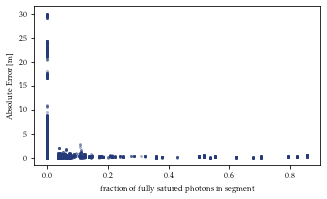

In [26]:
ax = bathy_pts_df.plot.scatter(y='error_abs',x='full_sat',figsize=set_size(fraction=0.75),ylabel='Absolute Error [m]',rasterized=True,xlabel='fraction of fully satured photons in segment',s=4,alpha=0.3)
# ax.rast
ax.get_figure().savefig('../document/figures/error_by_full_sat.pdf')

# Analysis of tracklines by site
going to start from scratch

In [27]:
bathy_pts_df.groupby(["site", "date", "beam"]).agg(np.mean)

X          Y    Z_ellip    Z_geoid  \
site            date       beam                                               
charlotteamalie 2018-11-22 gt1l -64.909433  18.405369 -56.129138 -11.564461   
                           gt1r -64.915244  18.357089 -54.897201 -10.456566   
                           gt2l -64.947799  18.327885 -50.609892  -6.254161   
                           gt2r -64.949536  18.318618 -51.616048  -7.259257   
                           gt3l -64.976783  18.341017 -49.128370  -4.748831   
...                                    ...        ...        ...        ...   
stcroix         2021-12-15 gt1r -64.847951  17.669176 -52.092978  -8.489442   
                           gt2l -64.877354  17.669371 -52.564237  -8.872614   
                           gt2r -64.877940  17.671653 -51.765971  -8.064654   
                2022-03-15 gt2l -64.764100  17.672771 -58.796830 -15.271503   
                           gt3l -64.794097  17.675386 -54.989821 -11.446517   

                                 geoid_corr  tide_ocean_corr  geof2m_corr  \
site            date       beam                                             
charlotteamalie 2018-11-22 gt1l  -44.655016        -0.183779     0.090339   
                           gt1r  -44.531168        -0.172846     0.090533   
                           gt2l  -44.446381        -0.167639     0.090650   
                           gt2r  -44.447478        -0.165495     0.090687   
                           gt3l  -44.470136        -0.172252     0.090597   
...                                     ...              ...          ...   
stcroix         2021-12-15 gt1r  -43.696786        -0.083813     0.093250   
                           gt2l  -43.784873        -0.083550     0.093249   
                           gt2r  -43.794558        -0.083550     0.093240   
                2022-03-15 gt2l  -43.618563        -0.005797     0.093236   
                           gt3l  -43.636530        -0.005993     0.093226   

                                 oc_sig_conf  land_sig_conf  p_vec_az  ...  \
site            date       beam                                        ...   
charlotteamalie 2018-11-22 gt1l     3.636364       3.636364 -1.568716  ...   
                           gt1r     3.892086       3.920863 -1.933917  ...   
                           gt2l     2.166667       3.735294 -1.634106  ...   
                           gt2r     1.856502       3.896861 -2.264461  ...   
                           gt3l     3.421875       3.562500  2.612902  ...   
...                                      ...            ...       ...  ...   
stcroix         2021-12-15 gt1r     2.551622       3.607670  1.742342  ...   
                           gt2l     2.880562       3.956674  1.491413  ...   
                           gt2r     2.684825       3.856031  1.710539  ...   
                2022-03-15 gt2l     0.408163       0.380952  0.583314  ...   
                           gt3l     1.186100       1.077858  1.318850  ...   

                                  kde_val  oc_hconf_perc  n_subsurf_points  \
site            date       beam                                              
charlotteamalie 2018-11-22 gt1l  0.105156      94.712824             451.0   
                           gt1r  0.150415      96.346765            1745.0   
                           gt2l  0.136556      94.710615             656.0   
                           gt2r  0.120637      96.456881            1928.0   
                           gt3l  0.121838      95.118919             569.0   
...                                   ...            ...               ...   
stcroix         2021-12-15 gt1r  0.180389      96.247639             984.0   
                           gt2l  0.131014      96.336958            2128.0   
                           gt2r  0.131747      96.163232             653.0   
                2022-03-15 gt2l  0.106341      51.849537            2145.0   
                           gt3l  0.116321      55.786161    

In [28]:
error_by_transect = bathy_pts_df.groupby(["site", "date", "beam"]).agg(
    **unpackable_error_dict
)
error_by_transect

RMS Error [m]   MAE [m]  Mean Error [M]  \
site            date       beam                                            
charlotteamalie 2018-11-22 gt1l       0.917383  0.799143        0.381374   
                           gt1r       0.466839  0.340227        0.164312   
                           gt2l       3.650315  2.566434       -2.116037   
                           gt2r       1.800616  1.201450       -0.766739   
                           gt3l       0.148725  0.097550        0.069846   
...                                        ...       ...             ...   
stcroix         2021-12-15 gt1r       1.729840  1.318498       -1.088719   
                           gt2l       0.657330  0.432050       -0.171566   
                           gt2r       0.781079  0.526942       -0.092972   
                2022-03-15 gt2l       0.993448  0.959139        0.959139   
                           gt3l       0.366838  0.294623       -0.177783   

                                 n bathy points  
site            date       beam                  
charlotteamalie 2018-11-22 gt1l              11  
                           gt1r             417  
                           gt2l             102  
                           gt2r             223  
                           gt3l              64  
...                                         ...  
stcroix         2021-12-15 gt1r             339  
                           gt2l             854  
                           gt2r             257  
                2022-03-15 gt2l             147  
                           gt3l            2633  

[472 rows x 4 columns]

In [29]:
secchi_tracklines = secchi_pt_combined.assign(date=pd.to_datetime(secchi_pt_combined.date).dt.date).groupby(['date','beam','site']).median()

In [30]:
final_trackline_summary = tracklines_combined.merge(
    error_by_transect, on=["site", "date", "beam"], how="left"
).replace({"n bathy points": np.NaN}, value=0).merge(secchi_tracklines,on=["site", "date", "beam"],how='left')

final_trackline_summary["ph_per_m"] = (
    final_trackline_summary.n_photons / final_trackline_summary["length"]
)

In [31]:
beamtype = bathy_pts_df[bathy_pts_df.true_elevation<=0].groupby("beamtype").agg(**unpackable_error_dict)
beamtype.style.format(precision=2).to_latex('../document/tables/rmse_by_strongweak.tex',
position='htbp',
position_float='centering',
                                             label='tab:error-by-strongweak',
                                             caption='Error Metrics per-transect based on beam type',
                                            hrules=True
                                            )
beamtype

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
beamtype,,,,
strong,0.830920,0.348512,0.168561,353374
weak,0.704058,0.396069,0.058358,54566


In [32]:
final_trackline_summary.columns

Index(['file', 'beam', 'rgt', 'date', 'beam_type', 'n_photons', 'p_hconf',
       'avg_ph_cou', 'avg_fsat', 'length', 'geometry', 'site', 'RMS Error [m]',
       'MAE [m]', 'Mean Error [M]', 'n bathy points', 'zsd', 'sigma_zsd',
       'diff_atten', 'diff_atten_unc', 'X', 'Y', 'gebco_elev', 'ph_per_m'],
      dtype='object')

In [33]:
final_trackline_summary.groupby(final_trackline_summary["n bathy points"] == 0).mean()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
n bathy points,,,,,,,,,,,,,,,,,
False,50677.625000,84.044618,124.403288,0.006850,13503.861562,0.80405,0.660451,0.007657,864.279661,22.721781,41.230477,0.05346,53.468912,-103.403754,20.816936,-129.732759,3.883386
True,79943.250811,50.183749,326.315384,0.005785,9055.686553,NaN,NaN,NaN,0.000000,27.731426,29.878141,0.03903,41.187618,-121.854219,20.433090,-111.696344,10.144761


In [59]:
final_trackline_summary.to_pickle('notebooks/all_tracklines.pkl')

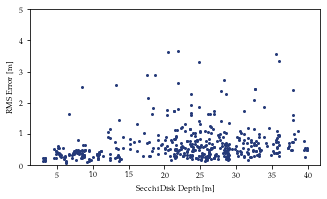

In [61]:
ax = final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="zsd", figsize=set_size(fraction=0.75),ylim=(0,5),xlabel="Secchi Disk Depth [m]",s=4,rasterized=True
    # rasterized=True
)
ax.get_figure().savefig('../document/figures/track_secchi_vs_rmse.pdf')

<AxesSubplot:xlabel='avg_ph_cou', ylabel='RMS Error [m]'>

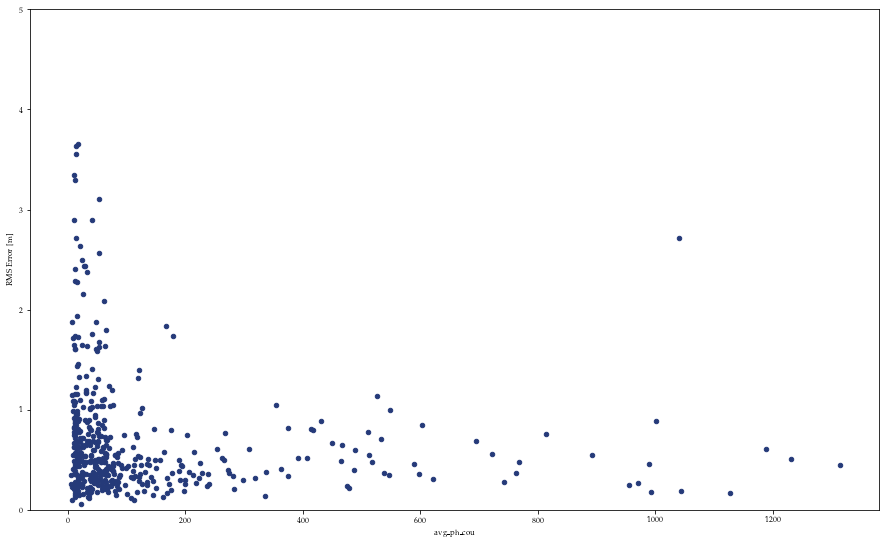

In [36]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="avg_ph_cou", figsize=set_size(fraction=2), ylim=(0, 5)
)

<AxesSubplot:xlabel='avg_ph_cou', ylabel='n bathy points'>

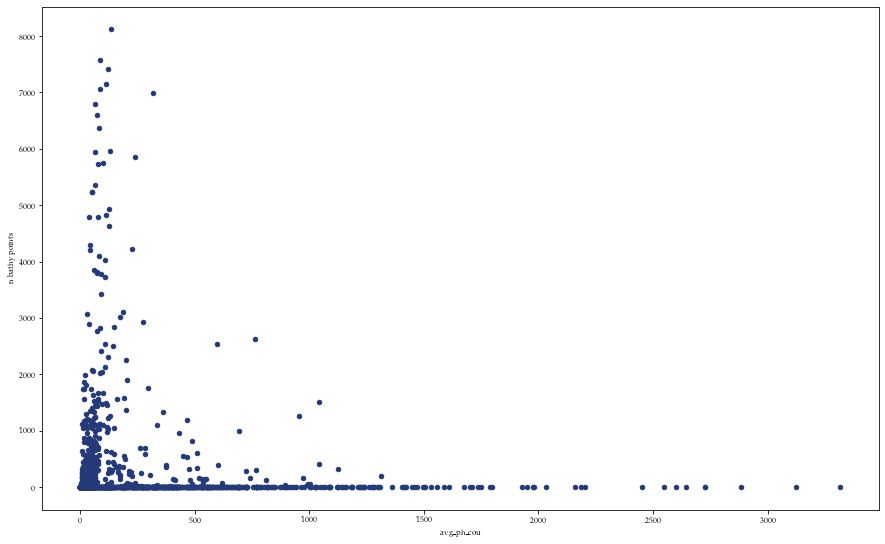

In [37]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="avg_ph_cou", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='ph_per_m', ylabel='n bathy points'>

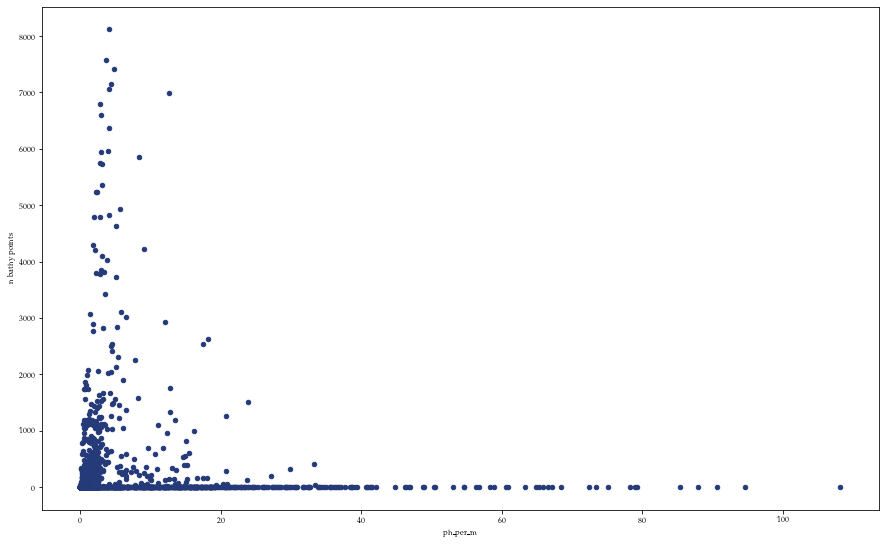

In [38]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="ph_per_m", figsize=set_size(fraction=2)
)

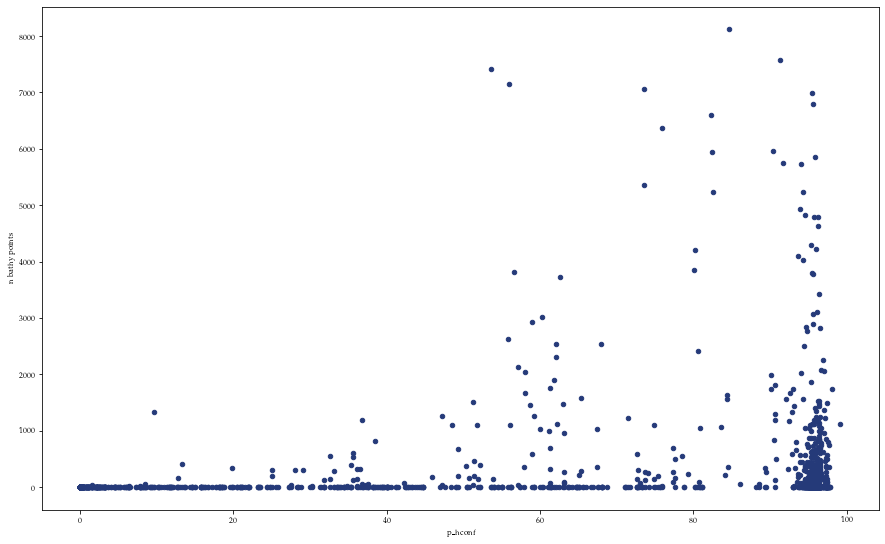

In [39]:
ax = final_trackline_summary.plot.scatter(
    y="n bathy points", x="p_hconf", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='avg_fsat', ylabel='n bathy points'>

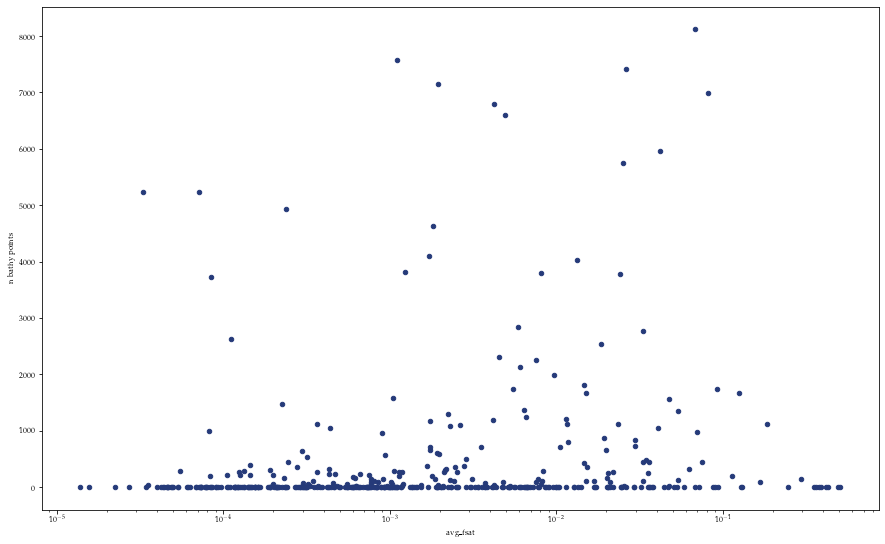

In [40]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="avg_fsat", figsize=set_size(fraction=2),logx=True
)

In [41]:
final_trackline_summary['RMS Error [m]'].median()

0.5021020928188075

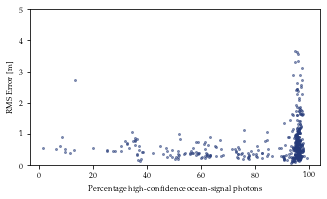

In [42]:
ax = final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="p_hconf", figsize=set_size(fraction=0.75), ylim=(0, 5),s=4,rasterized=True,alpha=0.5,xlabel='Percentage high-confidence ocean-signal photons'
)

ax.get_figure().savefig('../document/figures/track_hconf_oc_vs_rmse.pdf')

<AxesSubplot:xlabel='avg_fsat', ylabel='RMS Error [m]'>

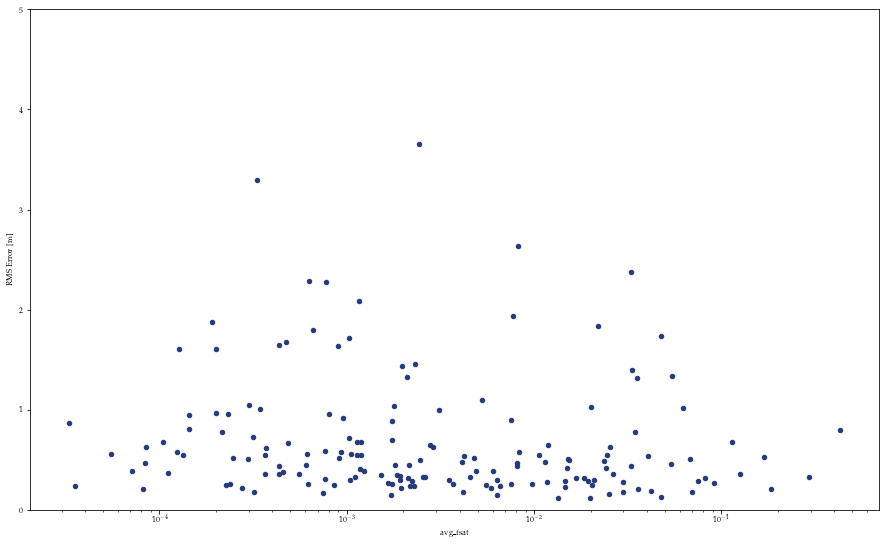

In [43]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="avg_fsat", figsize=set_size(fraction=2), ylim=(0, 5),logx=True
)

<AxesSubplot:xlabel='ph_per_m', ylabel='RMS Error [m]'>

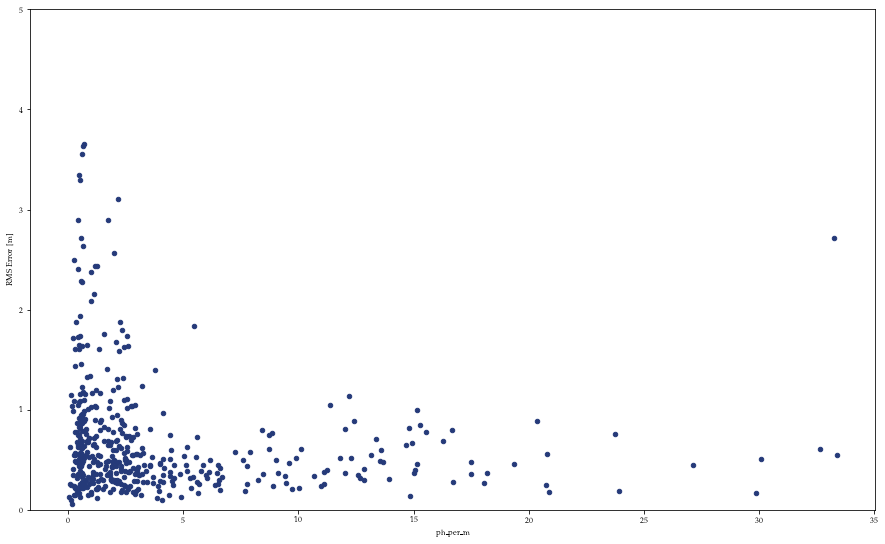

In [44]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="ph_per_m", figsize=set_size(fraction=2), ylim=(0, 5)
)

In [45]:
final_trackline_summary.corr()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
n_photons,1.000000,-0.482354,0.745970,0.019796,0.168567,-0.089591,-0.072363,0.084006,-0.019370,0.113465,-0.088326,-0.087776,-0.099837,-0.006756,-0.059506,-0.072280,0.771585
p_hconf,-0.482354,1.000000,-0.581033,0.057227,0.104200,0.017030,-0.006171,-0.176475,0.186642,-0.096084,0.054825,0.080107,0.071365,0.129212,-0.040802,-0.014657,-0.575350
avg_ph_cou,0.745970,-0.581033,1.000000,-0.035621,-0.171066,-0.063379,-0.047538,0.081855,-0.107456,0.216033,-0.124354,-0.167034,-0.138577,-0.242671,0.057416,0.014101,0.946449
avg_fsat,0.019796,0.057227,-0.035621,1.000000,0.120452,-0.030274,-0.021912,0.027455,0.030613,-0.169539,0.112821,0.183913,0.127538,0.096063,0.132881,0.005059,-0.033797
length,0.168567,0.104200,-0.171066,0.120452,1.000000,-0.115977,-0.118332,0.063163,0.263645,-0.433828,0.243490,0.339071,0.205844,0.723258,-0.289795,-0.280890,-0.196062
RMS Error [m],-0.089591,0.017030,-0.063379,-0.030274,-0.115977,1.000000,0.994808,-0.406682,-0.121244,0.060965,-0.056439,-0.026526,-0.063341,-0.095717,0.018965,0.082110,-0.066572
MAE [m],-0.072363,-0.006171,-0.047538,-0.021912,-0.118332,0.994808,1.000000,-0.402796,-0.109378,0.052095,-0.039752,-0.009964,-0.045477,-0.103471,0.035513,0.076451,-0.049369
Mean Error [M],0.084006,-0.176475,0.081855,0.027455,0.063163,-0.406682,-0.402796,1.000000,0.049816,-0.105205,0.032321,0.116643,0.048400,0.017235,0.075963,0.019661,0.096035
n bathy points,-0.019370,0.186642,-0.107456,0.030613,0.263645,-0.121244,-0.109378,0.049816,1.000000,-0.420626,0.314853,0.462771,0.341297,0.190007,0.346306,0.062434,-0.095112
zsd,0.113465,-0.096084,0.216033,-0.169539,-0.433828,0.060965,0.052095,-0.105205,-0.420626,1.000000,-0.588852,-0.829637,-0.554134,-0.465799,-0.287519,-0.146242,0.245842


In [46]:
final_trackline_summary.cov()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
n_photons,1.177385e+10,-2.042151e+06,3.306625e+07,75.916703,1.078042e+08,-11662.859170,-9262.817753,11293.219714,-1.929434e+06,100536.294113,-170587.480065,-235.327679,-207898.796149,-31005.481150,-13008.387010,-1.594834e+06,1.067395e+06
p_hconf,-2.042151e+06,1.522388e+03,-9.261213e+03,0.082174,2.396274e+04,0.632059,-0.225212,-6.764016,6.685314e+03,-32.349008,40.233222,0.081605,56.467036,225.684893,-3.394451,-1.230738e+02,-2.862046e+02
avg_ph_cou,3.306625e+07,-9.261213e+03,1.668819e+05,-0.529502,-4.118825e+05,-22.758612,-16.785138,30.353737,-4.029816e+04,702.937421,-881.972164,-1.644520,-1059.710284,-4089.364098,46.085334,1.142384e+03,4.929284e+03
avg_fsat,7.591670e+01,8.217368e-02,-5.295025e-01,0.001356,2.612324e+01,-0.001420,-0.001007,0.001330,1.012582e+00,-0.051131,0.075191,0.000161,0.091436,0.152093,0.009793,3.674736e-02,-1.529695e-02
length,1.078042e+08,2.396274e+04,-4.118825e+05,26.123244,3.473848e+07,-1096.544226,-1100.124826,616.710226,1.426506e+06,-21949.525591,26852.541360,51.908238,24476.271836,189626.701869,-3618.994899,-3.540499e+05,-1.473264e+04
RMS Error [m],-1.166286e+04,6.320585e-01,-2.275861e+01,-0.001420,-1.096544e+03,3.024518,2.958571,-1.270218,-2.983587e+02,1.013392,-1.795278,-0.001649,-2.317984,-7.175163,0.087563,3.234944e+01,-6.261535e-01
MAE [m],-9.262818e+03,-2.252121e-01,-1.678514e+01,-0.001007,-1.100125e+03,2.958571,2.924352,-1.237073,-2.646658e+02,0.852151,-1.244330,-0.000609,-1.637718,-7.629566,0.161286,2.962719e+01,-4.565921e-01
Mean Error [M],1.129322e+04,-6.764016e+00,3.035374e+01,0.001330,6.167102e+02,-1.270218,-1.237073,3.225448,1.265942e+02,-1.804602,1.060931,0.007482,1.827765,1.334597,0.362308,8.001577e+00,9.327904e-01
n bathy points,-1.929434e+06,6.685314e+03,-4.029816e+04,1.012582,1.426506e+06,-298.358733,-264.665823,126.594238,8.427505e+05,-3451.176111,5630.883147,11.488809,6581.171723,8057.581754,699.498894,1.272858e+04,-1.113186e+03
zsd,1.005363e+05,-3.234901e+01,7.029374e+02,-0.051131,-2.194953e+04,1.013392,0.852151,-1.804602,-3.451176e+03,75.030126,-96.302779,-0.188348,-97.712443,-181.337491,-5.345964,-2.743872e+02,2.402470e+01


In [47]:
final_trackline_summary.columns

Index(['file', 'beam', 'rgt', 'date', 'beam_type', 'n_photons', 'p_hconf',
       'avg_ph_cou', 'avg_fsat', 'length', 'geometry', 'site', 'RMS Error [m]',
       'MAE [m]', 'Mean Error [M]', 'n bathy points', 'zsd', 'sigma_zsd',
       'diff_atten', 'diff_atten_unc', 'X', 'Y', 'gebco_elev', 'ph_per_m'],
      dtype='object')

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

In [49]:
final_trackline_summary.count()

file              1397
beam              1397
rgt               1397
date              1397
beam_type         1397
n_photons         1397
p_hconf           1397
avg_ph_cou        1397
avg_fsat          1297
length            1397
geometry          1397
site              1397
RMS Error [m]      472
MAE [m]            472
Mean Error [M]     472
n bathy points    1397
zsd               1302
sigma_zsd         1302
diff_atten        1302
diff_atten_unc    1302
X                 1312
Y                 1312
gebco_elev        1312
ph_per_m          1397
dtype: int64

In [50]:
# get the dependant variables and standardize them from 0-1
x = final_trackline_summary.loc[
    :, ["n_photons", "p_hconf", "avg_ph_cou", "length", "n bathy points", "ph_per_m"]
].to_numpy()
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = final_trackline_summary.loc[:, "n bathy points"].to_numpy() <= 5

pcs = PCA(
    n_components=2,
).fit_transform(x)

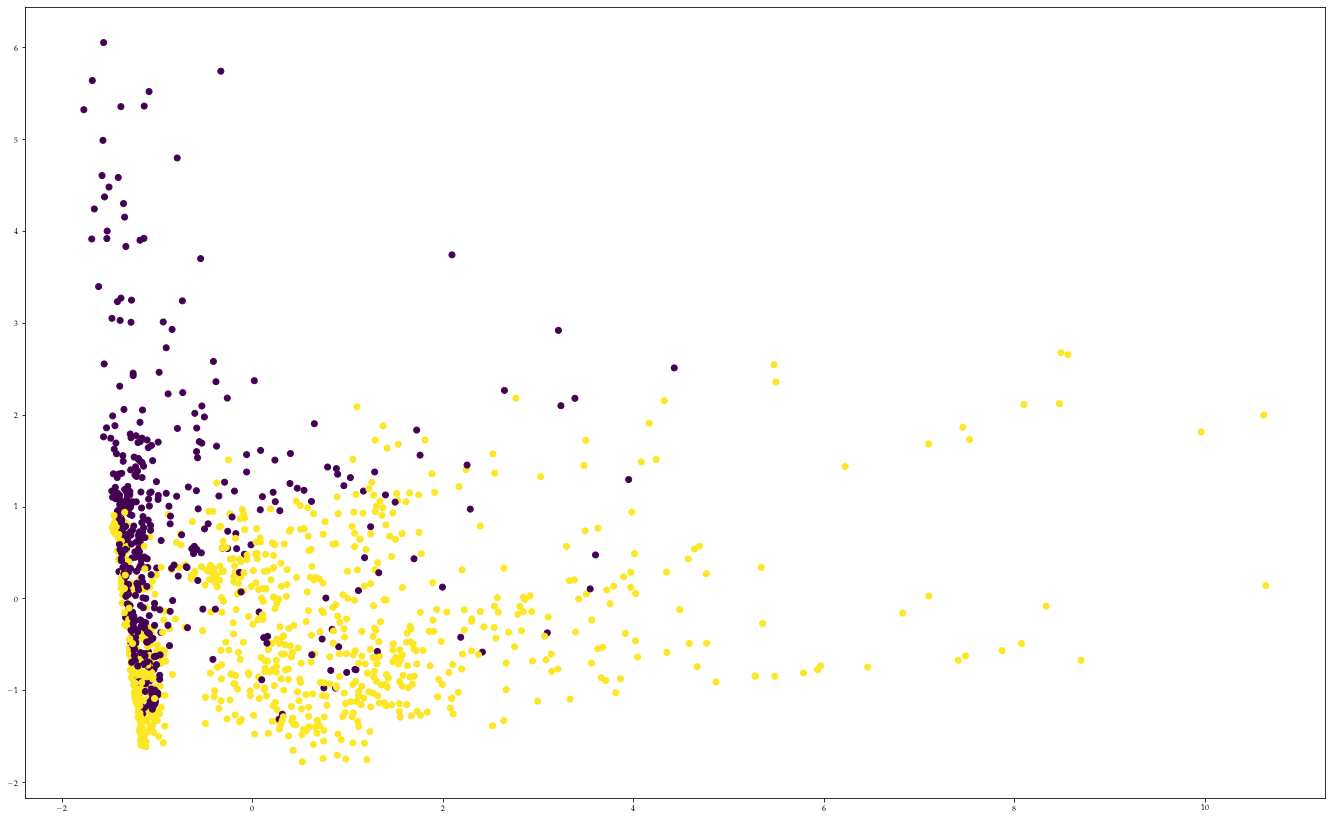

In [51]:
fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:, 0], pcs[:, 1], c=y)

# PCA for each point to identify error

In [52]:
columns_of_interest = [
    "ph_count",
    "gebco_elev",
    "sea_level_interp",
    "sea_level_std_dev",
    "kde_val",
    "beamtype",
    "oc_hconf_perc",
    "n_subsurf_points",
    "n_total_points",
]

x = (
    bathy_pts_df.assign(beamtype=(bathy_pts_df.beamtype == "weak").astype("int"))
    .loc[:, columns_of_interest]
    .to_numpy()
)
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = bathy_pts_df.loc[:, "error_abs"].to_numpy()

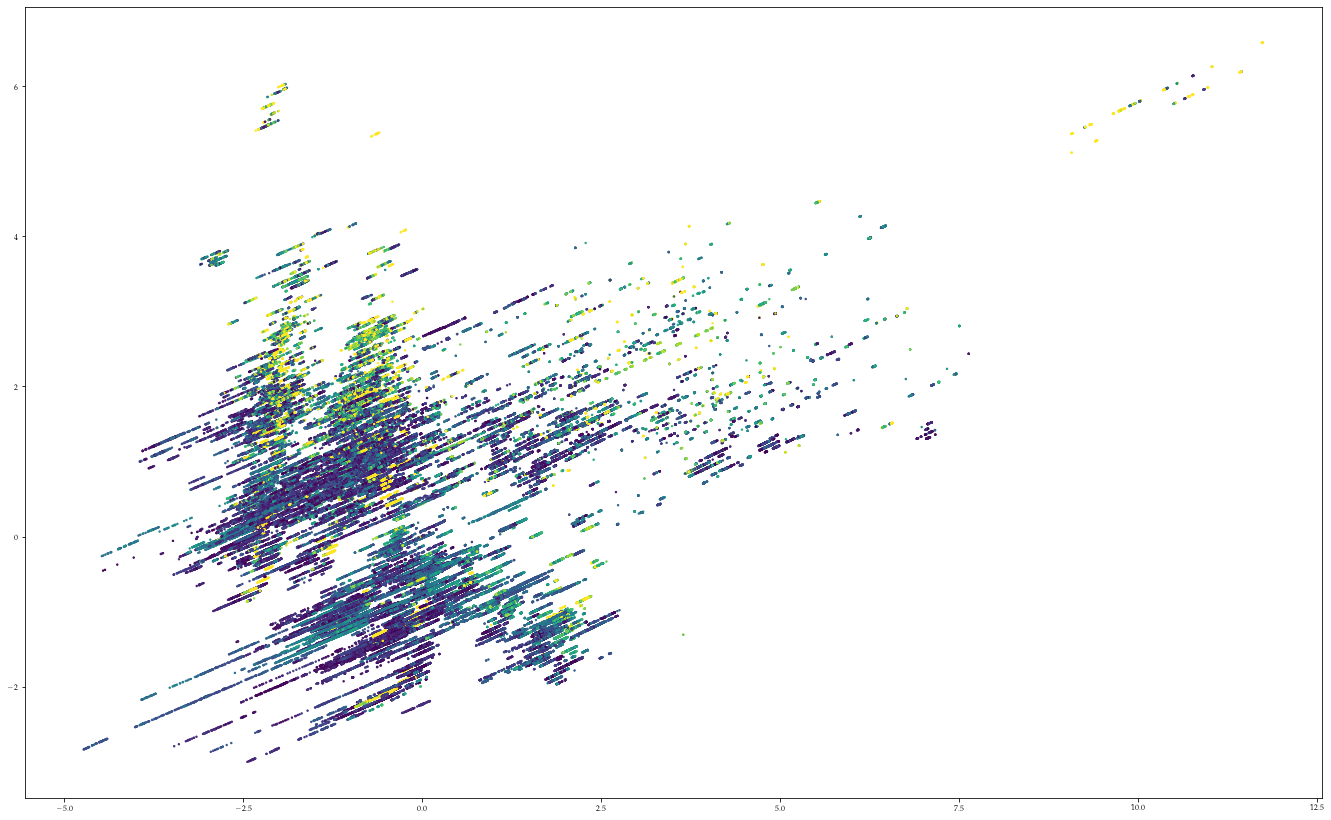

In [53]:
pcs = TruncatedSVD(n_components=2).fit_transform(x)

fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:, 0], pcs[:, 1], c=y, s=2, vmax=1)

(0.0, 1.0)

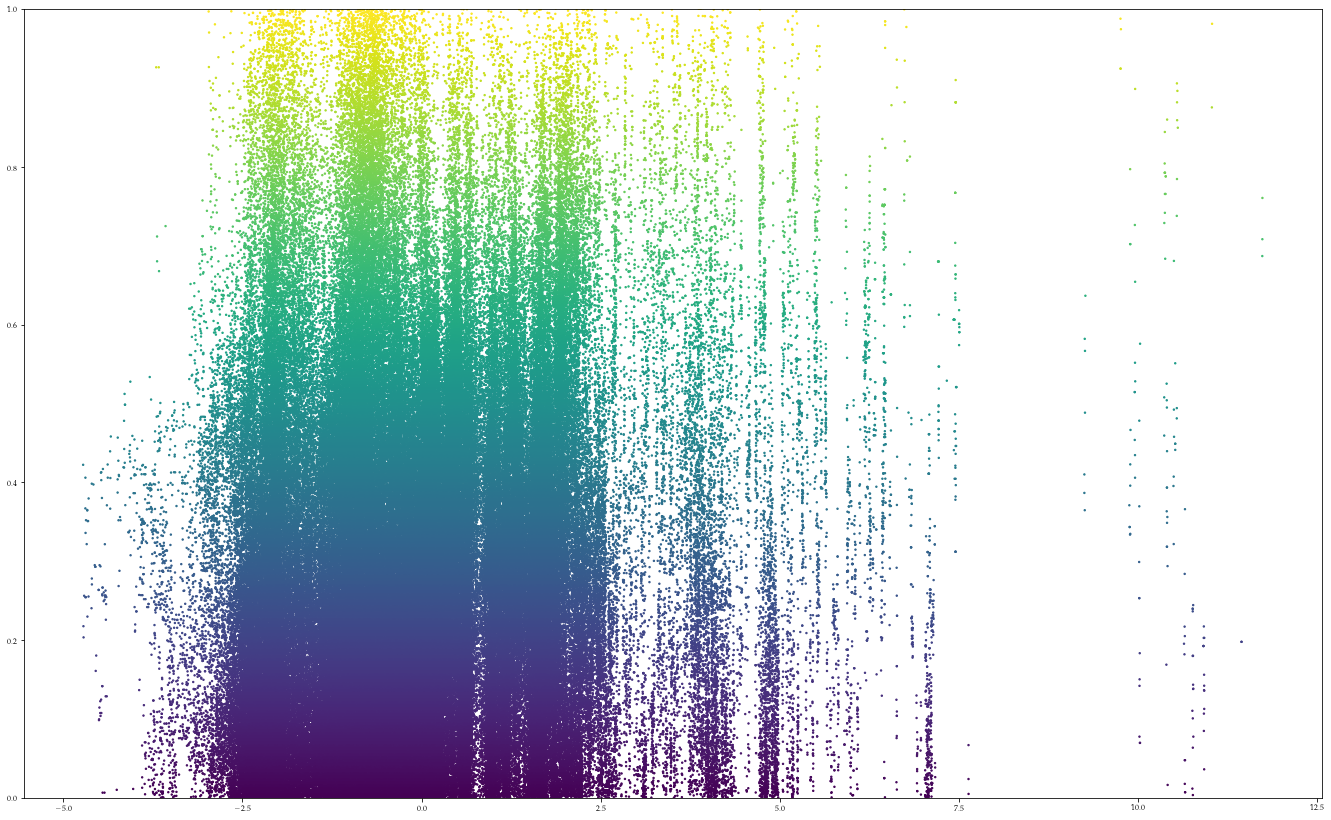

In [54]:
pcs = TruncatedSVD(n_components=1).fit_transform(x)

fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs, y, c=y, s=2, vmax=1)
ax.set_ylim(0, 1)

# Bias plot of all sites

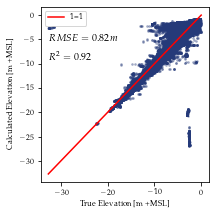

In [55]:
from atl_module.error_calc import icesat_error_metrics
bathy_pts_minus_oahu2 = bathy_pts_df[bathy_pts_df.true_elevation<0]
edict = icesat_error_metrics(bathy_pts_minus_oahu2)
fig = error_lidar_pt_vs_truth_pt(bathy_pts_minus_oahu2,edict)
ax  = fig.axes[0]
# ax.set_xlim((-25,0))
# ax.set_ylim((-25,0))
fig.savefig('../document/figures/all_points_biasplot.pdf')

In [56]:
final_trackline_summary

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,...,Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
0,processed_ATL03_20181118180604_07810101_005_01,gt1l,781,2018-11-18,weak,57485,5.200868,148.215500,0.000046,13661.191363,...,NaN,0.0,18.876167,13.130000,0.047461,20.750000,-65.059733,18.358089,-33.0,4.207905
1,processed_ATL03_20181118180604_07810101_005_01,gt1r,781,2018-11-18,strong,75310,68.725040,131.635878,0.000000,13680.730945,...,NaN,0.0,18.876167,13.130000,0.047461,20.750000,-65.059064,18.357974,-31.5,5.504823
2,processed_ATL03_20181118180604_07810101_005_01,gt2l,781,2018-11-18,weak,52136,7.932656,94.177862,0.000048,14462.224446,...,NaN,0.0,19.369091,23.789999,0.046458,23.789999,-65.030114,18.365074,-31.0,3.604978
3,processed_ATL03_20181118180604_07810101_005_01,gt2r,781,2018-11-18,strong,64474,62.957850,110.641437,0.000000,14483.648451,...,NaN,0.0,19.369091,23.789999,0.046458,23.789999,-65.029421,18.364951,-31.0,4.451503
4,processed_ATL03_20181118180604_07810101_005_01,gt3l,781,2018-11-18,weak,58996,2.100001,124.933606,0.000042,15263.922124,...,NaN,0.0,20.565153,33.610001,0.044224,33.610001,-64.999199,18.359623,-43.5,3.865062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,processed_ATL03_20220315201713_12761407_005_01,gt1r,1276,2022-03-15,weak,48147,2.183704,128.155524,0.000078,18924.447299,...,NaN,0.0,31.734207,39.180000,0.031675,39.180000,-64.733935,17.679570,-743.0,2.544169
1393,processed_ATL03_20220315201713_12761407_005_01,gt2l,1276,2022-03-15,strong,315773,51.849537,548.077090,0.003100,20842.088629,...,0.959139,147.0,31.108919,50.579998,0.032127,55.809998,-64.763423,17.679271,-596.0,15.150737
1394,processed_ATL03_20220315201713_12761407_005_01,gt2r,1276,2022-03-15,weak,117079,4.900382,242.992484,0.013580,20306.917716,...,NaN,0.0,31.108919,50.579998,0.032127,55.809998,-64.764270,17.679178,-596.0,5.765474
1395,processed_ATL03_20220315201713_12761407_005_01,gt3l,1276,2022-03-15,strong,380147,55.786161,763.082147,0.000112,20880.586849,...,-0.177783,2633.0,28.455942,51.230000,0.034285,62.270000,-64.793723,17.678887,-441.0,18.205762


In [57]:
final_trackline_summary.columns

Index(['file', 'beam', 'rgt', 'date', 'beam_type', 'n_photons', 'p_hconf',
       'avg_ph_cou', 'avg_fsat', 'length', 'geometry', 'site', 'RMS Error [m]',
       'MAE [m]', 'Mean Error [M]', 'n bathy points', 'zsd', 'sigma_zsd',
       'diff_atten', 'diff_atten_unc', 'X', 'Y', 'gebco_elev', 'ph_per_m'],
      dtype='object')

In [58]:
bysite_summary = final_trackline_summary.groupby('site').agg({'beam':'count','p_hconf':'median','Mean Error [M]':'count','MAE [m]':'mean','zsd':'median'}).rename(columns={'Mean Error [M]':'Count transects with bathy','beam':'count total transects'})

bysite_summary['percent of tracklines with bathymetry']=bysite_summary['Count transects with bathy']/bysite_summary['count total transects']

bysite_summary = bysite_summary.merge(
bysite_summary

SyntaxError: unexpected EOF while parsing (597711961.py, line 6)

In [ ]:
bysite_summary.plot.scatter(x='p_hconf',y='percent of tracklines with bathymetry')

In [ ]:
site_error_secchi = bathy_pts_minus_oahu2.groupby('site').agg(**unpackable_error_dict)
# .merge(secchi_pt_combined.groupby('site').median(),how='left',on=['site'])
site_error_secchi

In [ ]:
site_error_secchi.plot.scatter(x='zsd',y='RMS Error [m]',xlabel='Secchi Disk Depth [m]',figsize=set_size(fraction=0.75))

In [ ]:
site_error_secchi

# rmse decrease by site

In [ ]:
rasterrorr_list = []
for oahucsvfile in glob('../document/tables/*.csv'):
    name = oahucsvfile.strip('../document/tables',).strip('_kalman_improvement.csv')
    df = pd.read_csv(oahucsvfile,names=['Error Type','RMSE [m]','MAE [m]','Mean Error [m]'],header=0)
    df['sitename']=name
    rasterrorr_list.append(df)
rastererrordf = pd.concat(rasterrorr_list).set_index(['sitename','Error Type'])
rastererrordf


In [ ]:
summarydf = rastererrordf.unstack()

In [ ]:
percent_change = pd.DataFrame(
    {
        "RMSE Change":(summarydf['RMSE [m]']['GEBCO'] - summarydf['RMSE [m]']['Kalman Output'])/summarydf['RMSE [m]']['GEBCO'].abs(),
        "MAE Change":(summarydf['MAE [m]']['GEBCO'] - summarydf['MAE [m]']['Kalman Output'])/summarydf['MAE [m]']['GEBCO'].abs(),
        "Mean Error Change":(summarydf['Mean Error [m]']['GEBCO'] - summarydf['Mean Error [m]']['Kalman Output'])/summarydf['Mean Error [m]']['GEBCO'],

    }
)
percent_change

In [ ]:
# percent_change.style.format(formatter='{:,.2%}').to_latex(buf='.')
percent_change.style.format(formatter='{:,.2%}',escape='latex').to_latex(buf='../document/tables/alls-ite_percent_change.tex',                              
   caption="Percent reduction in error metrics via the Kalman updating approach. Positive values indicate reduced error, negative ones indicate increased error.",
    position="htbp",
    position_float='centering',
    sparse_columns=False,
    hrules=True,
    label="tab:oahu-percent-change",
    )

In [ ]:
for name, group in rastererrordf.reset_index().groupby('sitename'):
    print(name)